# BLIP Modelini COCO ile Oluşturulmuş Özelleştirilmiş Veri Seti ile Görsel Soru-Cevaplama (Visual Question Answering) İçin Fine-Tune Etme

Bu projede, **Salesforce/blip-vqa-base** modeli, **COCO** veri seti kullanılarak oluşturulmuş özelleştirilmiş bir veri seti ile **fine-tuning** işlemine tabi tutulmuştur.

Model, görseller üzerinden sorulan sorulara doğru yanıtlar verebilmek amacıyla **AutoProcessor**, **AutoModelForVisualQuestionAnswering** ve **Trainer** kullanılarak eğitilmiştir. Bu süreç sonunda model, **görsel soru-cevaplama (Visual Question Answering)** görevlerinde başarı sağlamıştır.

### Veri Seti
Veri seti, **COCO** veri seti ile özelleştirilerek oluşturulmuş, görüntüleri ve bu görüntülerle ilgili soruları içermektedir. Eğitim verisi, %80 eğitim ve %20 değerlendirme (test) olacak şekilde bölünmüştür.

### Kullanılan Donanım

- Kaggle Notebook: Tesla P100

![image](../imgs/vqa.png)

In [1]:
# GPU ve CUDA sürümlerini kontrol etmek için kullanılır
!nvidia-smi

Sun Oct 13 19:55:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# warnings kütüphanesi uyarıları kapatmak için kullanılır
import warnings 
warnings.filterwarnings("ignore")

In [3]:
!pip install -q -U transformers datasets huggingface_hub
!echo "Installations completed!"

Installations completed!


In [4]:
from huggingface_hub import notebook_login
# Giriş yapmadan önce Huggingface Hub'a üye olmanız gerekmektedir
# Settings kısmından API token oluşturabilirsiniz
notebook_login()

In [5]:
from datasets import load_dataset
import requests
from io import BytesIO
from PIL import Image

from transformers import AutoProcessor, AutoModelForVisualQuestionAnswering
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

import torch 
from torch.utils.data import Dataset
from datasets.formatting.formatting import LazyBatch

from transformers import pipeline
import matplotlib.pyplot as plt

## 🤗 Hugging Face Datasets Kütüphanesi

### Parametreler

- **`path`**:
  - Yüklenecek veri setinin yolu veya ismi. Örnek: "imdb", "glue".

- **`name`**:
  - Yüklenecek veri setinin alt kümesi. Örnek: "sst2" (GLUE için).

- **`data_dir`**:
  - Veri dosyalarının bulunduğu dizin.

- **`data_files`**:
  - Yüklenecek veri dosyaları.

- **`split`**:
  - Veri setinin bölünmesi (örneğin "train", "test").

- **`cache_dir`**:
  - Verinin önbelleğe alınacağı dizin.

- **`features`**:
  - Özelliklerin açıkça belirtildiği yer.

- **`download_config`**:
  - İndirme yapılandırma ayarları.

- **`download_mode`**:
  - İndirme modu: "reuse_dataset_if_exists", "reuse_cache_if_exists", "force_redownload".

- **`verification_mode`**:
  - Veri setinin doğrulama modu.

- **`ignore_verifications`**:
  - Artık kullanılmıyor, doğrulamaları atlamak için.

- **`keep_in_memory`**:
  - Eğer True ise, veri seti bellekte tutulur.

- **`save_infos`**:
  - Eğer True ise, veri seti bilgileri kaydedilir.

- **`revision`**:
  - Yüklenecek veri setinin versiyonu veya commit ID'si.

- **`token`**:
  - Private veri setleri için kullanılır, bir token sağlar.

- **`use_auth_token`**:
  - Artık kullanılmıyor, oturum açma token'ı için.

- **`task`**:
  - Artık kullanılmıyor, veri seti yükleme görevini belirtmek için.

- **`streaming`**:
  - Eğer True ise, veri seti akış modunda yüklenir.

- **`num_proc`**:
  - Çok işlemcili veri işleme için işlemci sayısı.

- **`storage_options`**:
  - Depolama seçenekleri.

- **`trust_remote_code`**:
  - Eğer True ise, uzaktan kod çalıştırmaya izin verir.

- **`**config_kwargs`**:
  - Diğer ek yapılandırma argümanları.

In [6]:
def get_img(batch):
    """
    ## Get Image
    Bu fonksiyon, veri kümesindeki resim URL'lerini alır ve resimleri yükler.

    Args:
        - batch: Veri kümesinden bir toplu işlem
    
    Returns:
        - dict: Resimlerin yüklenmiş hali
    """
    if isinstance(batch, LazyBatch):
        images = []
        for url in batch['image_url']:
            response = requests.get(url)
            image = BytesIO(response.content)
            image = Image.open(image)
            image = image.convert("RGB")
            images.append(image)

        return {'image': images}
    
    elif isinstance(batch, str): 
        response = requests.get(batch)
        image = BytesIO(response.content)
        image = Image.open(image)
        image = image.convert("RGB")

        return image

dataset = load_dataset("fawern/visual-question-answering-coco", split='train[:10]')
dataset = dataset.map(get_img, batched=True)

dataset = dataset.train_test_split(train_size=0.8)
train_dataset, eval_dataset = dataset['train'], dataset['test']

print(train_dataset)

README.md:   0%|          | 0.00/344 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/217 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['image_url', 'question', 'answer', 'image'],
    num_rows: 8
})


## 🤗 BlipProcessor

### Parametreler

- **`images`**:
  - İşlenecek görüntü verileri. Desteklenen formatlar: `PIL.Image.Image`, `numpy.ndarray`, `torch.Tensor` ve bu formatların listeleri.

- **`text`**:
  - İşlenecek metin verisi. String ya da string listesi formatında olabilir.

- **`add_special_tokens`**:
  - Eğer True ise, özel tokenlar eklenir. Varsayılan değer: `True`.

- **`padding`**:
  - Padding stratejisini belirler. `False`, `True`, veya belirli bir padding stratejisi (`max_length` ya da `longest`) olabilir. Varsayılan değer: `False`.

- **`truncation`**:
  - Eğer True ise, veriyi keser. Kesme stratejisi olarak `True`, `False`, veya belirli bir strateji (`longest_first`, `only_first`, `only_second`) kullanılabilir.

- **`max_length`**:
  - Verinin kesilmesi gereken maksimum uzunluk. Bu değer belirlenmezse, modelin varsayılan uzunluğu kullanılır.

- **`stride`**:
  - Kesme işlemi sırasında atlanacak adım sayısı. Varsayılan değer: `0`.

- **`pad_to_multiple_of`**:
  - Padding yapılacaksa, padding’in belirtilen sayının katı olacak şekilde yapılmasını sağlar.

- **`return_attention_mask`**:
  - Eğer True ise, attention mask döner. Varsayılan değer: `None`.

- **`return_overflowing_tokens`**:
  - Eğer True ise, kesilme sonucu fazla olan tokenları döner. Varsayılan değer: `False`.

- **`return_special_tokens_mask`**:
  - Eğer True ise, özel tokenları maskeleme bilgisi döner. Varsayılan değer: `False`.

- **`return_offsets_mapping`**:
  - Eğer True ise, her token için başlangıç ve bitiş offset bilgilerini döner. Varsayılan değer: `False`.

- **`return_token_type_ids`**:
  - Eğer True ise, token tipi kimlikleri döner. Varsayılan değer: `False`.

- **`return_length`**:
  - Eğer True ise, döndürülen verinin uzunluğunu içerir. Varsayılan değer: `False`.

- **`verbose`**:
  - Eğer True ise, işlem sırasında detaylı çıktılar verir. Varsayılan değer: `True`.

- **`return_tensors`**:
  - Döndürülecek tensor formatı. Desteklenen formatlar: `str`, `TensorType`, veya `None`.

- **`**kwargs`**:
  - Diğer ek yapılandırma parametreleri.

In [7]:
base_model_name = 'Salesforce/blip-vqa-base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

processor = AutoProcessor.from_pretrained(base_model_name)

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

## 🤗 AutoModelForVisualQuestionAnswering

### Parametreler

- **`pretrained_model_name_or_path`**:
  - Yüklenmek üzere önceden eğitilmiş modelin adı veya yolu. Bu argüman, aşağıdaki seçeneklerden biri olabilir:
    - Hugging Face modeli ID'si, örneğin: `"dandelin/vilt-b32-finetuned-vqa"`.
    - Kaydedilmiş model ağırlıklarını içeren bir dizin, örneğin: `"./my_model_directory/"`.
    - TensorFlow checkpoint dosyasının yolu veya URL'si, örneğin: `"./tf_model/model.ckpt.index"`. Bu durumda `from_tf=True` ayarlanmalıdır.

- **`model_args`**:
  - Modele iletilecek ek pozisyonel argümanlar.

- **`config`**:
  - Yüklemek için kullanılacak model yapılandırması. Bu yapılandırma otomatik olarak yükleneceği gibi, manuel olarak da sağlanabilir.

- **`state_dict`**:
  - Kaydedilmiş ağırlıklar yerine kullanılacak bir durum sözlüğü. Kaydedilmiş ağırlıkları kullanmadan modeli başlatmak istenirse bu seçenek kullanılabilir.

- **`cache_dir`**:
  - Önceden eğitilmiş modelin önbelleğe alınacağı dizin.

- **`from_tf`**:
  - Eğer True ise, TensorFlow checkpoint dosyasından model ağırlıkları yüklenir. Varsayılan değer: `False`.

- **`force_download`**:
  - Eğer True ise, mevcut önbellekteki dosyalar yerine model dosyaları yeniden indirilir. Varsayılan değer: `False`.

- **`proxies`**:
  - Protokol veya uç noktalara göre kullanılacak proxy sunucuları. Örneğin: `{'http': 'foo.bar:3128'}`.

- **`output_loading_info`**:
  - Eğer True ise, yükleme sırasında eksik veya beklenmeyen anahtarlar gibi bilgileri içeren bir sözlük döner.

- **`local_files_only`**:
  - Eğer True ise, yalnızca yerel dosyalara bakılır, uzaktan model indirilmez. Varsayılan değer: `False`.

- **`revision`**:
  - Kullanılacak modelin belirli bir versiyonu. Bir branch adı, tag adı veya commit ID'si olabilir. Varsayılan değer: `"main"`.

- **`trust_remote_code`**:
  - Eğer True ise, Hugging Face Hub üzerindeki özelleştirilmiş modellerin kodunu çalıştırmaya izin verir. Varsayılan değer: `False`.

- **`code_revision`**:
  - Eğer modelin kodu farklı bir repo'da yer alıyorsa, bu argüman ile o repo'nun belirli bir versiyonu kullanılabilir. Varsayılan değer: `"main"`.

- **`kwargs`**:
  - Model yapılandırmasını güncellemek veya başlatmak için kullanılabilecek ek anahtar argümanlar. Sağlanan yapılandırmaya göre davranış değişir.

In [ ]:
model = AutoModelForVisualQuestionAnswering.from_pretrained(base_model_name).to(device)

## 🤗 Tokenizer Encode

### Parametreler

- **`text`**:
  - Tokenize edilecek ilk dizi. String, string listesi (tokenized string), ya da integer listesi (token ID'leri) olabilir.

- **`text_pair`**:
  - Opsiyonel olarak encode edilecek ikinci dizi. Bu da string, string listesi (tokenized string), ya da integer listesi (token ID'leri) olabilir.

- **`add_special_tokens`**:
  - Eğer True ise, özel tokenlar dizilere eklenir. Varsayılan değer: `True`.

- **`padding`**:
  - Padding stratejisini belirler. Kabul edilen değerler:
    - `True` veya `'longest'`: En uzun diziyi baz alarak pad ekler.
    - `'max_length'`: Belirtilen `max_length` ile ya da modelin maksimum uzunluğuna kadar pad ekler.
    - `False` veya `'do_not_pad'`: Pad eklenmez (varsayılan).

- **`truncation`**:
  - Kesme stratejisini belirler. Kabul edilen değerler:
    - `True` veya `'longest_first'`: Maksimum uzunluğa kadar keser.
    - `'only_first'`: Yalnızca ilk diziyi keser.
    - `'only_second'`: Yalnızca ikinci diziyi keser.
    - `False` veya `'do_not_truncate'`: Kesme yapılmaz (varsayılan).

- **`max_length`**:
  - Kesme veya padding yapılacak maksimum uzunluk. Varsayılan olarak modelin maksimum uzunluğu kullanılır.

- **`stride`**:
  - Kesme sırasında döndürülen fazlalık tokenların dizilere eklenmesi için atlanacak adım sayısı. Varsayılan: `0`.

- **`is_split_into_words`**:
  - Eğer True ise, girişin kelimelere ayrıldığı varsayılır. Bu özellikle Named Entity Recognition (NER) gibi token sınıflandırma görevlerinde faydalıdır.

- **`pad_to_multiple_of`**:
  - Eğer belirtilirse, dizi bu değerin katları olacak şekilde padlenir. Padding etkinleştirildiğinde kullanılır.

- **`padding_side`**:
  - Pad'in dizinin hangi tarafına uygulanacağını belirler. `right` veya `left` olabilir. Varsayılan sınıf özniteliği ile aynı değerdedir.

- **`return_tensors`**:
  - Eğer belirtilirse, python integer listesi yerine tensor döndürür. Kabul edilen değerler:
    - `'tf'`: TensorFlow `tf.constant` nesneleri döner.
    - `'pt'`: PyTorch `torch.Tensor` nesneleri döner.
    - `'np'`: Numpy `np.ndarray` nesneleri döner.

- **`**kwargs`**:
  - Tokenize etme işlemi için ek parametreler.

### Dönüş:
- `List[int]`, `torch.Tensor`, `tf.Tensor`, veya `np.ndarray`: Tokenize edilmiş dizinin ID'lerini döner.

In [8]:
class VisualQADataset(Dataset):
    '''
    # VisualQADataset
    Bu sınıf, veri kümesini işlemek için kullanılır.
    '''
    def __init__(self, dataset, processor):
        '''
        # __init__
        Bu fonksiyon, sınıfı başlatır.

        Args:
            - dataset: Veri kümesi
            - processor: İşlemci
        
        Returns:
            - None
        '''
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        '''
        # __len__
        Bu fonksiyon, veri kümesinin uzunluğunu döndürür.

        Returns:
            - int: Veri kümesinin uzunluğu
        '''
        return len(self.dataset)

    def __getitem__(self, idx):
        '''
        # __getitem__
        Bu fonksiyon, veri kümesinden bir öğeyi döndürür.

        Args:
            - idx: İndeks
        
        Returns:
            - dict: İşlenmiş veri
        '''
        item = self.dataset[idx]
    
        image = item['image']

        question = item['question']
        answer = item['answer']

        encoding = self.processor(
            images=image,
            text=question,
            truncation=True,
            padding="max_length",  
            max_length=32,
            return_tensors="pt",
        )

        encoding['labels'] = self.processor.tokenizer.encode(
            answer, padding='max_length', max_length=32, truncation=True, return_tensors='pt'
        )
        
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        return encoding

In [9]:
train_dataset = VisualQADataset(train_dataset, processor)
eval_dataset = VisualQADataset(eval_dataset, processor)

## 🤗 Hugging Face Seq2SeqTrainingArguments Kütüphanesi

### Parametreler

- **`output_dir`**:
  - Model tahminlerinin ve kontrol noktalarının kaydedileceği dizin.

- **`overwrite_output_dir`**:
  - Eğer True ise, `output_dir` içeriği üzerine yazılır.

- **`do_train`**:
  - Eğitim işleminin yapılıp yapılmayacağını belirtir.

- **`do_eval`**:
  - Değerlendirme işleminin yapılıp yapılmayacağını belirtir.

- **`do_predict`**:
  - Tahmin işleminin yapılıp yapılmayacağını belirtir.

- **`eval_strategy`**:
  - Değerlendirme stratejisi: 'no', 'steps' veya 'epoch'.

- **`prediction_loss_only`**:
  - Eğer True ise, sadece kayıp hesaplanır, tahminler döndürülmez.

- **`per_device_train_batch_size`**:
  - Her bir cihaz (GPU/CPU) için eğitim batch boyutu.

- **`per_device_eval_batch_size`**:
  - Her bir cihaz (GPU/CPU) için değerlendirme batch boyutu.

- **`gradient_accumulation_steps`**:
  - Gradient biriktirme adımları. Yüksek değerler bellek kullanımını azaltır ama eğitim süresini uzatır.

- **`eval_accumulation_steps`**:
  - Değerlendirme biriktirme adımları. Yüksek değerler bellek kullanımını azaltır ama değerlendirme süresini uzatır.

- **`eval_delay`**:
  - Eğitim başladıktan sonra ilk değerlendirmenin yapılacağı adım sayısı.

- **`learning_rate`**:
  - Öğrenme oranı. Yüksek değerler daha hızlı öğrenir ama aşırı öğrenmeye (overfitting) yol açabilir.

- **`weight_decay`**:
  - Ağırlıkların küçülme oranı. Yüksek değerler modelin genelleme yeteneğini artırabilir ama öğrenme yavaşlar.

- **`adam_beta1`**:
  - Adam optimizasyon algoritması için beta1 parametresi.

- **`adam_beta2`**:
  - Adam optimizasyon algoritması için beta2 parametresi.

- **`adam_epsilon`**:
  - Adam optimizasyon algoritması için epsilon parametresi.

- **`max_grad_norm`**:
  - Gradientlerin maksimum normu. Büyük değerler modelin stabilitesini artırabilir.

- **`num_train_epochs`**:
  - Eğitim için epoch sayısı. Yüksek değerler daha fazla öğrenme sağlar ama aşırı öğrenmeye yol açabilir.

- **`max_steps`**:
  - Maksimum eğitim adım sayısı. -1 ise, tüm epoch'lar tamamlanır.

- **`lr_scheduler_type`**:
  - Öğrenme oranı zamanlayıcı tipi.

- **`lr_scheduler_kwargs`**:
  - Öğrenme oranı zamanlayıcısı için ek parametreler.

- **`warmup_ratio`**:
  - Öğrenme oranı ısınma oranı. Yüksek değerler başlangıçta daha yavaş öğrenme sağlar.

- **`warmup_steps`**:
  - Öğrenme oranı ısınma adım sayısı. Yüksek değerler başlangıçta daha yavaş öğrenme sağlar.

- **`log_level`**:
  - Log seviyesi. 'passive', 'info', 'warning', 'error' veya 'critical'.

- **`log_level_replica`**:
  - Çoklu GPU eğitiminde log seviyesi.

- **`log_on_each_node`**:
  - Çoklu node eğitiminde her node için loglama yapılır.

- **`logging_dir`**:
  - TensorBoard logları için dizin.

- **`logging_strategy`**:
  - Loglama stratejisi: 'no', 'steps' veya 'epoch'.

- **`logging_first_step`**:
  - Eğer True ise, ilk adımda loglama yapılır.

- **`logging_steps`**:
  - Kaç adımda bir loglama yapılacağı.

- **`logging_nan_inf_filter`**:
  - Eğer True ise, NaN ve sonsuz değerler loglanmaz.

- **`save_strategy`**:
  - Modelin kaydedilme stratejisi: 'no', 'steps' veya 'epoch'.

- **`save_steps`**:
  - Kaç adımda bir modelin kaydedileceği.

- **`save_total_limit`**:
  - Maksimum kaç model kaydedileceği.

- **`save_safetensors`**:
  - Modelin güvenli tensör formatında kaydedilip kaydedilmeyeceği.

- **`save_on_each_node`**:
  - Eğer True ise, her node'da model kaydedilir.

- **`save_only_model`**:
  - Eğer True ise, sadece model kaydedilir, optimizer ve lr scheduler kaydedilmez.

- **`restore_callback_states_from_checkpoint`**:
  - Callback durumlarının checkpoint'ten geri yüklenip yüklenmeyeceği.

- **`no_cuda`**:
  - Eğer True ise, GPU kullanılmaz.

- **`use_cpu`**:
  - Eğer True ise, CPU kullanılır.

- **`use_mps_device`**:
  - Eğer True ise, MacOS Metal Performance Shaders kullanılır.

- **`seed`**:
  - Rastgelelik için seed değeri.

- **`data_seed`**:
  - Veri yükleme için seed değeri.

- **`jit_mode_eval`**:
  - Eğer True ise, PyTorch JIT modu kullanılır.

- **`use_ipex`**:
  - Eğer True ise, Intel Extension for PyTorch kullanılır.

- **`bf16`**:
  - Eğer True ise, bfloat16 kullanılır.

- **`fp16`**:
  - Eğer True ise, float16 kullanılır.

- **`fp16_opt_level`**:
  - float16 optimizasyon seviyesi.

- **`half_precision_backend`**:
  - Yarı hassasiyet arka ucu: 'auto', 'amp' veya 'apex'.

- **`bf16_full_eval`**:
  - Eğer True ise, bfloat16 tam değerlendirme yapılır.

- **`fp16_full_eval`**:
  - Eğer True ise, float16 tam değerlendirme yapılır.

- **`tf32`**:
  - Eğer True ise, TensorFloat-32 kullanılır.

- **`local_rank`**:
  - Çoklu GPU eğitiminde lokal rank.

- **`ddp_backend`**:
  - DDP backend tipi: 'nccl', 'gloo', 'mpi'.

- **`tpu_num_cores`**:
  - TPU çekirdek sayısı.

- **`tpu_metrics_debug`**:
  - TPU metriklerinin debug bilgilerini içerir.

- **`debug`**:
  - Debug seçeneği: 'underflow_overflow', 'tpu_metrics_debug'.

- **`dataloader_drop_last`**:
  - Eğer True ise, dataloader son batch'i düşürür.

- **`eval_steps`**:
  - Değerlendirme adım sayısı.

- **`dataloader_num_workers`**:
  - Dataloader için çalışan sayısı. Yüksek değerler hız artırır ama daha fazla bellek kullanır.

- **`dataloader_prefetch_factor`**:
  - Dataloader için prefetch faktörü. Yüksek değerler hız artırır ama daha fazla bellek kullanır.

- **`past_index`**:
  - Geçmiş index.

- **`run_name`**:
  - Çalışma ismi.

- **`disable_tqdm`**:
  - Eğer True ise, tqdm progress bar devre dışı bırakılır.

- **`remove_unused_columns`**:
  - Eğer True ise, kullanılmayan sütunlar veri setinden kaldırılır.

- **`label_names`**:
  - Label isimleri.

- **`load_best_model_at_end`**:
  - Eğitim sonunda en iyi modelin yüklenip yüklenmeyeceği.

- **`metric_for_best_model`**:
  - En iyi modelin seçilmesi için kullanılacak metrik.

- **`greater_is_better`**:
  - Eğer True ise, metriklerde yüksek değerler daha iyi olarak kabul edilir.

- **`ignore_data_skip`**:
  - Eğer True ise, veri atlamaları göz ardı edilir.

- **`fsdp`**:
  - Fully Sharded Data Parallel ayarları.

- **`fsdp_min_num_params`**:
  - Fully Sharded Data Parallel için minimum parametre sayısı.

- **`fsdp_config`**:
  - Fully Sharded Data Parallel için ek ayarlar.

- **`fsdp_transformer_layer_cls_to_wrap`**:
  - Fully Sharded Data Parallel için transformer layer sınıfı.

- **`accelerator_config`**:
  - Accelerator için ek ayarlar.

- **`deepspeed`**:
  - DeepSpeed yapılandırması.

- **`label_smoothing_factor`**:
  - Label smoothing faktörü.

- **`optim`**:
  - Optimizasyon algoritması.

- **`optim_args`**:
  - Optimizasyon algoritması için ek argümanlar.

- **`adafactor`**:
  - Eğer True ise, Adafactor optimizasyon algoritması kullanılır.

- **`group_by_length`**:
  - Eğer True ise, input uzunluğuna göre gruplanır.

- **`length_column_name`**:
  - Uzunluk sütunu ismi.

- **`report_to`**:
  - Raporlama platformları (örneğin 'wandb').

- **`ddp_find_unused_parameters`**:
  - DDP'de kullanılmayan parametrelerin bulunması.

- **`ddp_bucket_cap_mb`**:
  - DDP bucket kapasitesi.

- **`ddp_broadcast_buffers`**:
  - DDP broadcast buffer'ları.

- **`dataloader_pin_memory`**:
  - Dataloader için bellek pinleme.

- **`dataloader_persistent_workers`**:
  - Dataloader için kalıcı çalışanlar.

- **`skip_memory_metrics`**:
  - Eğer True ise, bellek metrikleri atlanır.

- **`use_legacy_prediction_loop`**:
  - Eğer True ise, eski tahmin döngüsü kullanılır.

- **`push_to_hub`**:
  - Eğer True ise, model Hugging Face Hub'a itilir.

- **`resume_from_checkpoint`**:
  - Checkpoint'ten devam edilir.

- **`hub_model_id`**:
  - Hugging Face Hub model ID.

- **`hub_strategy`**:
  - Hub stratejisi.

- **`hub_token`**:
  - Hugging Face Hub token.

- **`hub_private_repo`**:
  - Eğer True ise, özel repo kullanılır.

- **`hub_always_push`**:
  - Eğer True ise, her zaman Hub'a itilir.

- **`gradient_checkpointing`**:
  - Eğer True ise, gradient checkpointing yapılır.

- **`gradient_checkpointing_kwargs`**:
  - Gradient checkpointing için ek argümanlar.

- **`include_inputs_for_metrics`**:
  - Eğer True ise, değerlendirme metrikleri için inputlar da dahil edilir.

- **`eval_do_concat_batches`**:
  - Eğer True ise, değerlendirme batch'leri birleştirilir.

- **`fp16_backend`**:
  - float16 arka ucu.

- **`evaluation_strategy`**:
  - Değerlendirme stratejisi: 'no', 'steps' veya 'epoch'.

- **`push_to_hub_model_id`**:
  - Hub model ID.

- **`push_to_hub_organization`**:
  - Hub organizasyon ID.

- **`push_to_hub_token`**:
  - Hub token.

- **`mp_parameters`**:
  - Model paralel parametreler.

- **`auto_find_batch_size`**:
  - Eğer True ise, batch boyutu otomatik bulunur.

- **`full_determinism`**:
  - Eğer True ise, deterministik eğitim yapılır.

- **`torchdynamo`**:
  - TorchDynamo kullanımı.

- **`ray_scope`**:
  - Ray scope.

- **`ddp_timeout`**:
  - DDP timeout süresi.

- **`torch_compile`**:
  - Eğer True ise, Torch compile kullanılır.

- **`torch_compile_backend`**:
  - Torch compile backend.

- **`torch_compile_mode`**:
  - Torch compile modu.

- **`dispatch_batches`**:
  - Batch dispatching.

- **`split_batches`**:
  - Batch splitting.

- **`include_tokens_per_second`**:
  - Eğer True ise, saniye başına token sayısı dahil edilir.

- **`include_num_input_tokens_seen`**:
  - Eğer True ise, görülen input token sayısı dahil edilir.

- **`neftune_noise_alpha`**:
  - Neptune noise alpha.

- **`optim_target_modules`**:
  - Optimizasyon hedef modüller.

- **`batch_eval_metrics`**:
  - Eğer True ise, batch değerlendirme metrikleri hesaplanır.

In [17]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="steps",
    save_steps=500,
    logging_dir='./logs',
    num_train_epochs=1,
    logging_steps=100,
    report_to='none',
    hub_model_id="fawern/blip-Visual-QuestionAnswering-coco"
)

## 🤗 Hugging Face Seq2SeqTrainer Kütüphanesi

### Parametreler

- **`model`**:
  - Eğitim ve değerlendirme için kullanılacak model. `PreTrainedModel` veya `torch.nn.Module` olmalıdır. Eğer belirtilmezse, bir `model_init` fonksiyonu verilmelidir.

- **`args`**:
  - Eğitim argümanları, `TrainingArguments` sınıfı ile oluşturulur. Eğer belirtilmezse, `output_dir` parametresi *tmp_trainer* olan temel bir `TrainingArguments` örneği kullanılır.

- **`data_collator`**:
  - Veriyi toplamak ve batch oluşturmak için kullanılan fonksiyon. Eğer belirtilmezse, `tokenizer` yoksa `default_data_collator`, varsa `DataCollatorWithPadding` kullanılır.

- **`train_dataset`**:
  - Eğitim için kullanılacak veri seti. `torch.utils.data.Dataset`, `torch.utils.data.IterableDataset` veya `datasets.Dataset` olabilir.

- **`eval_dataset`**:
  - Değerlendirme için kullanılacak veri seti. `torch.utils.data.Dataset`, `datasets.Dataset` veya bunların sözlük hali olabilir.

- **`tokenizer`**:
  - Metin verilerini modelin anlayabileceği sayısal değerlere dönüştürür. Eğer belirtilirse, girdileri otomatik olarak maksimum uzunluğa kadar pad eder ve modelle birlikte kaydedilir.

- **`model_init`**:
  - Modelin başlatılması için kullanılacak fonksiyon. Her `train` çağrısında yeni bir model örneği başlatmak için kullanılır.

- **`compute_metrics`**:
  - Değerlendirme metriklerini hesaplamak için kullanılacak fonksiyon. `EvalPrediction` alır ve metrik değerlerine sahip bir sözlük döndürür.

- **`callbacks`**:
  - Eğitim sürecini izlemek ve kontrol etmek için kullanılacak callback listesi. Varsayılan callback'lere ek olarak kullanılır.

- **`optimizers`**:
  - Optimizasyon algoritması ve öğrenme oranı zamanlayıcısı. Varsayılan olarak, `AdamW` optimizer ve `get_linear_schedule_with_warmup` zamanlayıcısı kullanılır.

- **`preprocess_logits_for_metrics`**:
  - Metrik hesaplama için logits'i ön işleme fonksiyonu. İki tensor alır, logits ve etiketler, ve işlenen logits'i döndürür. Etiketler (`labels`) eğer veri setinde yoksa `None` olabilir.


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [18]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=2, training_loss=7.326071739196777, metrics={'train_runtime': 14.8544, 'train_samples_per_second': 0.539, 'train_steps_per_second': 0.135, 'total_flos': 517633959936.0, 'train_loss': 7.326071739196777, 'epoch': 1.0})

In [19]:
trainer.push_to_hub()
processor.push_to_hub("fawern/blip-Visual-QuestionAnswering-coco")

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fawern/blip-Visual-QuestionAnswering-coco/commit/40c70d8f97fb785a78c8d415aa2afa3196be178e', commit_message='Upload processor', commit_description='', oid='40c70d8f97fb785a78c8d415aa2afa3196be178e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/fawern/blip-Visual-QuestionAnswering-coco', endpoint='https://huggingface.co', repo_type='model', repo_id='fawern/blip-Visual-QuestionAnswering-coco'), pr_revision=None, pr_num=None)

## 🤗 Hugging Face Pipeline

### Parametreler

- **`task`**:
  - Geri döndürülecek pipeline türünü tanımlar. Şu anda kabul edilen görevler şunlardır:
    - `"audio-classification"`: [`AudioClassificationPipeline`] döndürür.
    - `"automatic-speech-recognition"`: [`AutomaticSpeechRecognitionPipeline`] döndürür.
    - `"depth-estimation"`: [`DepthEstimationPipeline`] döndürür.
    - `"document-question-answering"`: [`DocumentQuestionAnsweringPipeline`] döndürür.
    - `"feature-extraction"`: [`FeatureExtractionPipeline`] döndürür.
    - `"fill-mask"`: [`FillMaskPipeline`] döndürür.
    - `"image-classification"`: [`ImageClassificationPipeline`] döndürür.
    - `"image-feature-extraction"`: [`ImageFeatureExtractionPipeline`] döndürür.
    - `"image-segmentation"`: [`ImageSegmentationPipeline`] döndürür.
    - `"image-to-image"`: [`ImageToImagePipeline`] döndürür.
    - `"image-to-text"`: [`ImageToTextPipeline`] döndürür.
    - `"mask-generation"`: [`MaskGenerationPipeline`] döndürür.
    - `"object-detection"`: [`ObjectDetectionPipeline`] döndürür.
    - `"question-answering"`: [`QuestionAnsweringPipeline`] döndürür.
    - `"summarization"`: [`SummarizationPipeline`] döndürür.
    - `"table-question-answering"`: [`TableQuestionAnsweringPipeline`] döndürür.
    - `"text2text-generation"`: [`Text2TextGenerationPipeline`] döndürür.
    - `"text-classification"` (alias `"sentiment-analysis"`): [`TextClassificationPipeline`] döndürür.
    - `"text-generation"`: [`TextGenerationPipeline`] döndürür.
    - `"text-to-audio"` (alias `"text-to-speech"`): [`TextToAudioPipeline`] döndürür.
    - `"token-classification"` (alias `"ner"`): [`TokenClassificationPipeline`] döndürür.
    - `"translation"`: [`TranslationPipeline`] döndürür.
    - `"video-classification"`: [`VideoClassificationPipeline`] döndürür.
    - `"visual-question-answering"`: [`VisualQuestionAnsweringPipeline`] döndürür.
    - `"zero-shot-classification"`: [`ZeroShotClassificationPipeline`] döndürür.
    - `"zero-shot-image-classification"`: [`ZeroShotImageClassificationPipeline`] döndürür.
    - `"zero-shot-audio-classification"`: [`ZeroShotAudioClassificationPipeline`] döndürür.
    - `"zero-shot-object-detection"`: [`ZeroShotObjectDetectionPipeline`] döndürür.

- **`model`**:
  - Pipeline tarafından kullanılacak model. Bu, model kimliği (string) ya da [`PreTrainedModel`] veya [`TFPreTrainedModel`] gibi eğitilmiş bir model olabilir. Eğer belirtilmezse, varsayılan model yüklenir.

- **`config`**:
  - Pipeline'ı başlatırken kullanılacak model yapılandırması. Model kimliği veya [`PretrainedConfig`] olabilir. Eğer belirtilmezse, görev için varsayılan yapılandırma kullanılır.

- **`tokenizer`**:
  - Pipeline tarafından kullanılacak tokenizer. Model kimliği veya [`PreTrainedTokenizer`] olabilir. Eğer belirtilmezse, model veya görev için varsayılan tokenizer yüklenir.

- **`feature_extractor`**:
  - Model için veriyi işlemek için kullanılacak feature extractor. Ses veya görüntü gibi NLP dışı modellerde kullanılır. Eğer belirtilmezse, görev için varsayılan extractor yüklenir.

- **`framework`**:
  - Kullanılacak framework, `"pt"` (PyTorch) veya `"tf"` (TensorFlow) olabilir. Eğer belirtilmezse, kurulu olan framework tercih edilir.

- **`revision`**:
  - Bir görev adı veya model kimliği verildiğinde, kullanılacak model sürümünü belirtir (dal adı, etiket adı, commit id'si olabilir).

- **`use_fast`**:
  - Eğer mümkünse, [`PreTrainedTokenizerFast`] kullanılıp kullanılmayacağını belirtir. Varsayılan `True`.

- **`token`**:
  - HTTP yetkilendirme için kullanılacak token. Eğer `True` ise, `huggingface-cli login` ile alınan token kullanılır.

- **`device`**:
  - Pipeline'ın hangi cihazda çalışacağını belirtir. Örneğin `"cpu"`, `"cuda:0"`, `"mps"`, veya GPU sıralaması gibi (örn., `1`).

- **`device_map`**:
  - Model'in belirli parçasını hangi cihazda çalıştırılacağını belirler. `accelerate` kütüphanesi varsa, `device_map="auto"` otomatik olarak optimize edilmiş bir yapı çıkarır.

- **`torch_dtype`**:
  - Model'in hangi tür hassasiyetle çalışacağını belirtir (örn. `torch.float16`, `torch.bfloat16`, `"auto"`).

- **`trust_remote_code`**:
  - Hub'daki özel modellerin yerel makinede çalışmasına izin verilip verilmeyeceğini belirtir. Sadece güvenilir kodlar için kullanılmalıdır.

- **`model_kwargs`**:
  - Model'in `from_pretrained(..., **model_kwargs)` fonksiyonuna geçirilecek ek argümanları içeren sözlük.

- **`kwargs`**:
  - Belirli pipeline'ın `init` fonksiyonuna geçirilecek diğer ek argümanlar.



In [20]:
pipe = pipeline("visual-question-answering", model="fawern/blip-Visual-QuestionAnswering-coco", device=0 if torch.cuda.is_available() else -1)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [21]:
def get_vqa(url, question):
    '''
    ## Get Visual Question Answering
    Bu fonksiyon, verilen resim URL'si ve soru için tahmin yapar.

    Args:
        - url: Resim URL'si
        - question: Soru
    
    Returns:
        - None
    '''
    img = get_img(url)
    result = pipe(question=question, image=img)
    
    print(f"Question: {question}")
    print(f"Answer: {result[0]['answer']}")
    plt.imshow(img)
    plt.axis('off')
    plt.show

Question: Which animal is this ?
Answer: gecko


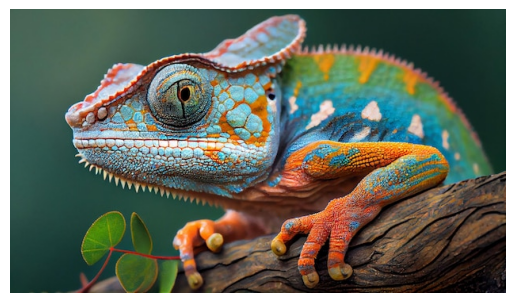

In [22]:
url = "https://img.freepik.com/free-photo/animal-lizard-nature-multi-colored-close-up-generative-ai_188544-9072.jpg"
question = "Which animal is this ?"

get_vqa(url, question)

Question: What is the price of Americano ?
Answer: 2. 00


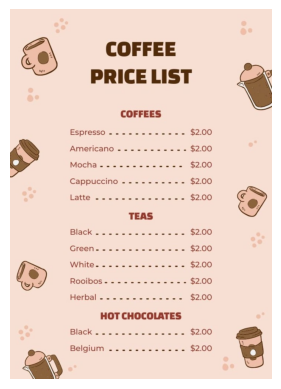

In [23]:
url = "https://content.wepik.com/statics/303151554/preview-page0.jpg"
question = "What is the price of Americano ?"

get_vqa(url, question)